In [2]:
%matplotlib inline

In [3]:
#import gym modules
import gym

In [98]:
# import pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

from torch.autograd import Variable

In [225]:
# import time to slow down rendering speed
import time
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from itertools import count

In [6]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [7]:
# create gym env
env = gym.make('BreakoutDeterministic-v4')

In [8]:
# reset it to return to the starting frame
frame = env.reset()

# render
# uncomment in an environment that can render frames
# env.render()

# loop until done
# random agent
is_done = False
while not is_done:
    # Perform random action, return new frame, reward and whether the game is completed
    frame, reward, is_done, _ = env.step(env.action_space.sample())

    # render next frame
    # uncomment in an environment that can render frames
    # env.render()

    # time.sleep()

In [9]:
# def q_iteration(env, model, state, iteration, memory):
#     # select an epsilon for epsilon-greedy exploration vs exploitation
#     epsilon = get_epsilon(iteration)

In [213]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(2240, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
#         print("1", x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
#         print("2", x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        print("3", x.shape)
#         xx = x.view(1, -1)
#         print("final", x.shape)
#         print(xx.shape)
        return self.head(x.view(x.size(0), -1))

In [219]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(5000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    print(sample)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    print(eps_threshold)
    if sample > eps_threshold:
        print("not random")
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        print("random")
        return LongTensor([[random.randrange(2)]])


episode_durations = []

# select_action(bb)


0.9936868617320129
0.9
not random
3 torch.Size([1, 32, 10, 7])



 1
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

In [222]:
memory_test = ReplayMemory(128)

In [223]:
memory.sample(128)

ValueError: Sample larger than population

In [232]:
last_sync = 0


def optimize_model():
    global last_sync
    
    # if population of the replay memory is not enough, don't do anything
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [104]:
params = list(model.parameters())

In [117]:
for i in range(len(params)):
    print(params[i].size())

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([2, 448])
torch.Size([2])


In [55]:
torch_frame


( 0 ,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

( 1 ,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

( 2 ,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0
... 

(207,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

(208,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

(209,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0
[torch.FloatTensor of size 210x160x3]

In [49]:
def to_grayscale(img):
    """
    turns an image into a grayscale image
    """
    return np.mean(img, axis=2).astype(np.uint8)

In [50]:
def downsample(img):
    """
    downsamples an image by taking everyone second pixel
    """
    return img[::2, ::2]

In [51]:
def preprocess(img):
    """
    preprocesses the image with grayscale and downsampling
    """
    return to_grayscale(downsample(img))

In [52]:
def transform_reward(reward):
    """
    returns the sign of the reward, so that the learning agent can be used in multiple games
    """
    return np.sign(reward)

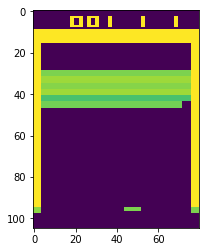

In [53]:
plt.imshow(preprocess(frame))

In [36]:
frame.shape

(210, 160, 3)

In [42]:
to_grayscale(frame)[100]

array([142, 142, 142, 142, 142, 142, 142, 142,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 142, 142, 142, 142,
       142, 142, 142, 142], dtype=uint8)

In [49]:
(to_grayscale(frame)/255)[:100]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.55686275,  0.55686275,  0.55686275, ...,  0.55686275,
         0.55686275,  0.55686275],
       [ 0.55686275,  0.55686275,  0.55686275, ...,  0.55686275,
         0.55686275,  0.55686275],
       [ 0.55686275,  0.55686275,  0.55686275, ...,  0.55686275,
         0.55686275,  0.55686275]])

In [78]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [25]:
def test():
    for i in range(10):
        action = env.action_space.sample()# take a random action
        a,b,c,d = env.step(action)
        plt.imshow(T.ToTensor())
        time.sleep(0.05)
        
    env.reset()

In [154]:
action = env.action_space.sample()# take a random action
a,b,c,d = env.step(action)
a.shape

(210, 160, 3)

In [62]:
resize = T.Compose([T.ToPILImage(),
                    T.Scale(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

NameError: name 'Image' is not defined

In [63]:
aa = torch.Tensor(preprocess(a))

In [64]:
aa


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 105x80]

AssertionError: Invalid permutation

In [56]:
plt.imshow(to_grayscale(aa))

TypeError: mean received an invalid combination of arguments - got (dtype=NoneType, axis=int, out=NoneType, ), but expected one of:
 * no arguments
 * (int dim, *, torch.FloatTensor out)
 * (int dim, bool keepdim, *, torch.FloatTensor out)
      didn't match because some of the keywords were incorrect: dtype, axis


In [46]:
aa

<function FloatTensor.unsqueeze>


( 0 ,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

( 1 ,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

( 2 ,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0
... 

(207,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

(208,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0

(209,.,.) = 
    0    0    0
    0    0    0
    0    0    0
       ⋮       
    0    0    0
    0    0    0
    0    0    0
[torch.cuda.FloatTensor of size 210x160x3 (GPU 0)]

In [163]:
from PIL import Image
resize = T.Compose([T.ToPILImage(),
                    T.ToTensor()])

def get_screen(a):
    print(a)
    screen = a.transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    print(screen.shape)
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

In [167]:
bb = get_screen(downsample(a))

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(3, 105, 80)


In [168]:
bb.shape

torch.Size([1, 3, 105, 80])

In [224]:
num_episodes = 10
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')

NameError: name 'count' is not defined

In [227]:
num_episodes = 10
for i_episode in range(num_episodes):
    # Initialize the environment and state
    init_obs = env.reset()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')

Box(210, 160, 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)